In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.cluster import KMeans
import math as m
import csv

In [105]:
# load suspects list:
df_suspects = pd.read_csv('downloads/jeopardy.csv')
df_suspects = df_suspects[df_suspects.suspicious == 1].cif.values.tolist()
len(df_suspects)

17141

In [2]:
# load data
df = pd.read_csv('downloads/large.csv')

In [3]:
df.head()

,cif,category,turnover,transaction_count,io_ratio,age,nationality,is_pep,inactive_days_average,inactive_days_max,n_of_accounts,distinct_counterparties,channel_risk,atm_withdrawal,atm_deposit
0,90000000,0,217673.05,125,0.304000,40,123,0,1.66,88,1,3,0.254742,1937.15,2161.790028
1,90000001,0,57.42,20,0.250000,17,90,0,7.32,88,4,6,0.393174,4.96,0.893866
2,90000002,0,1465076.90,1,0.000000,66,123,0,24.08,25,2,1,0.422991,0.00,229.333494
3,90000003,0,429840.54,46,0.239130,43,90,0,3.88,86,2,17,0.296019,43123.33,3121.939606
4,90000004,2,93356190.65,63,0.365079,0,186,0,2.77,100,1,1,0.067511,1814340.25,603026.545700


In [4]:
red_flag_countries = [33, 82, 113, 138, 187]

In [5]:
df_cpi = df[df.nationality.isin(red_flag_countries)]
#df_new[df_new['l_ext'].isin([31, 22, 30, 25, 64])]
len(df_cpi)

251750

In [6]:
df_cpi.head()

,cif,category,turnover,transaction_count,io_ratio,age,nationality,is_pep,inactive_days_average,inactive_days_max,n_of_accounts,distinct_counterparties,channel_risk,atm_withdrawal,atm_deposit
5,90000005,1,2184990.99,3,0.333333,0,82,0,51.96,52,2,1,0.311206,0.87,2670.491478
28,90000028,0,767598.70,2,0.000000,22,82,0,74.90,150,2,1,0.218999,0.00,1456.015838
29,90000029,1,138355.99,172,0.412791,0,33,0,1.02,100,4,96,0.111237,3229.40,149.532631
31,90000031,0,115204.98,2,0.500000,74,82,0,37.31,75,3,1,0.225440,15799.97,330.183237
34,90000034,0,150493.93,29,0.275862,33,82,0,4.17,76,2,7,0.070634,633.93,953.223518


In [29]:
# top 5% of values from below factors in risk countries:
def calculate_top5(df):
    for item in ['turnover', "transaction_count", "age", "inactive_days_average"]:
        #print(item)
        if item == "age":
            if len(df[df.nationality == 90]) > 0:
                trnover_list = np.array(df[df.nationality == 90].age.values.tolist()) # Japan is # 90
            else: trnover_list = np.array(df[item].values.tolist())
        else:
            trnover_list = np.array(df[item].values.tolist())
            
        trnover_list = trnover_list[trnover_list > 0] 
        #print(trnover_list[1:10])
        trnover_list = np.sort(trnover_list)
        #print(trnover_list[1:10])
        num5percent = int(len(trnover_list) - len(trnover_list)/100*5)
        print("top 5% "+ item +": > than ", trnover_list[num5percent])
        
calculate_top5(df_cpi)

top 5% turnover: > than  36818118.96
top 5% transaction_count: > than  140
top 5% age: > than  75
top 5% inactive_days_average: > than  149.02


In [8]:
df['Red_Flags'] = [0] * len(df)
df.head()

,cif,category,turnover,transaction_count,io_ratio,age,nationality,is_pep,inactive_days_average,inactive_days_max,n_of_accounts,distinct_counterparties,channel_risk,atm_withdrawal,atm_deposit,Red_Flags
0,90000000,0,217673.05,125,0.304000,40,123,0,1.66,88,1,3,0.254742,1937.15,2161.790028,0
1,90000001,0,57.42,20,0.250000,17,90,0,7.32,88,4,6,0.393174,4.96,0.893866,0
2,90000002,0,1465076.90,1,0.000000,66,123,0,24.08,25,2,1,0.422991,0.00,229.333494,0
3,90000003,0,429840.54,46,0.239130,43,90,0,3.88,86,2,17,0.296019,43123.33,3121.939606,0
4,90000004,2,93356190.65,63,0.365079,0,186,0,2.77,100,1,1,0.067511,1814340.25,603026.545700,0


In [80]:
# implementing features: how good we predict with all the features

#is_pep = 1

max_turnover = 36818118.96
max_age = 75
max_inactive_days_average = 149.02
max_transaction_count = 140

red_flag_list = df[(df.is_pep == 1) & (df.turnover > max_turnover)].cif.values.tolist()
red_flag_list += df[(df.is_pep == 1) & (df.age > max_age)].cif.values.tolist()
red_flag_list += df[(df.is_pep == 1) & (df.inactive_days_average > max_inactive_days_average)].cif.values.tolist()
red_flag_list += df[(df.is_pep == 1) & (df.transaction_count > max_transaction_count)].cif.values.tolist()
red_flag_list += df[(df.is_pep == 1) & (df.io_ratio < 0.5)].cif.values.tolist()

df.cif.isin(red_flag_list)


matches = 0
for cif_num in red_flag_list:
    if np.isin(cif_num, df_result): matches += 1
        
print("red flags: " + str(len(red_flag_list)), "matches: " + str(matches))

red flags: 6381 matches: 58


In [81]:
# implementing features: how good we predict with all the features

# df.age > max_age

max_turnover = 36818118.96
max_age = 75
max_inactive_days_average = 149.02
max_transaction_count = 140

red_flag_list += df[(df.age > max_age) & (df.inactive_days_average > max_inactive_days_average)].cif.values.tolist()
red_flag_list += df[(df.age > max_age) & (df.transaction_count > max_transaction_count)].cif.values.tolist()

df.cif.isin(red_flag_list)

matches = 0
for cif_num in red_flag_list:
    if np.isin(cif_num, df_result): matches += 1
        
print("red flags: " + str(len(red_flag_list)), "matches: " + str(matches))

red flags: 9426 matches: 111


In [67]:
red_flag_list_to_save = red_flag_list

In [73]:
red_flag_list = red_flag_list_to_save

In [82]:
len(red_flag_list)

9426

In [84]:
list(set(red_flag_list) & set(FLAG_D))

[90301218,
 90886082,
 90797833,
 90421452,
 90640848,
 90094705,
 90460051,
 90498006,
 90060984,
 90786297,
 90958139]

# Outliers in the dataset: example includes category Individuals

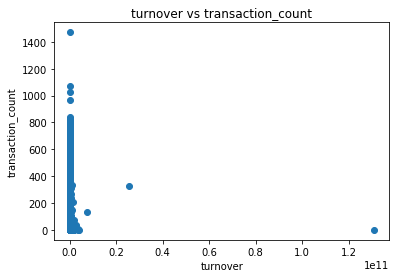

In [87]:
# Relation turnover and transaction_count; scatter plot

y_label = "transaction_count"
x_label = "turnover"
cat = 0

fig = plt.figure()
ax1 = fig.add_subplot(111)

import matplotlib.pyplot as plt
#plt.scatter(df['turnover'], df['transaction_count'])

ax1.scatter(df[df.category == cat].turnover, df[df.category == cat].transaction_count)

ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.set_title(x_label + " vs " + y_label)
plt.show()

In [123]:
ouliers_list = df[(df.category == 0) & (df.turnover > 0.07*1e11)].cif.values.tolist()
ouliers_list += df[(df.category == 0) & (df.transaction_count >900)].cif.values.tolist()

In [127]:
check_matches(ouliers_list)

Number of red flags: 7 False positives: 14.29%


In [126]:
def check_matches(rfList):
    matches = 0
    for element in rfList:
        if np.isin(element, df_result): matches += 1
    false_positives = (len(rfList)-matches)/len(rfList)*100
    print("Number of red flags: " + str(len(rfList)) + " False positives: " + str("{0:.2f}".format(false_positives)) + "%")

In [13]:
### Caushy distribution with parameters
def Caushy (x, g, x0, A):
    return float((A/m.pi)*g/((x-x0)**2+g*g))

In [18]:

cif = '\ufeffcif'
cif = 'cif'
susplist = df_result

#data_all_X = []
#data_all_Y = []
#data_susp_X = []
#data_susp_Y = []


a1_all_X = []
a1_all_Y = []
a1_susp_X = []
a1_susp_Y = []
a1_non_X = []
a1_non_Y = []




with open('downloads/large.csv', 'r') as data:
    reader = csv.DictReader(data, delimiter = ",")     
    for line in reader:
        if int(line['category']) == 0 and int(line['age']) > 0 and int(line['age']) >0:
           
            
            a1_all_X.append(float(line['io_ratio'])) # 
            a1_all_Y.append(float(line['transaction_count']))
            if int(line[cif]) in susplist:
                a1_susp_X.append(float(line['io_ratio']))
                a1_susp_Y.append(float(line['transaction_count']))
            else:
                a1_non_X.append(float(line['io_ratio']))
                a1_non_Y.append(float(line['transaction_count']))
            

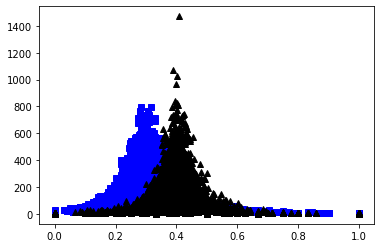

In [20]:
#### OBSERVE how different the distributions are!!!!
        
plt.plot(a1_non_X, a1_non_Y, 'bs')
plt.plot (a1_susp_X, a1_susp_Y, 'k^')
plt.show()        

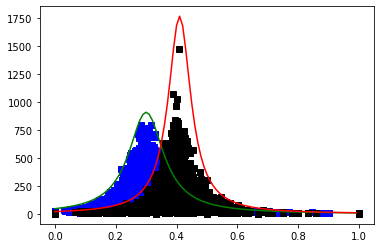

In [22]:
### HERE the choice of parameters was performed
### the tails of both distributions are too heavy to be gaussian
### so the Caushy distribution was chosen
### now the parameters are chosen manually, that can easily be improved 
### (optimisation problem solved by gradient descent technique ex.g)



gn = 0.07
x0n = 0.3
An = 200

gs = 0.045
x0s = 0.41
As = 250

x = np.arange(0., 1., 0.01)
ys = [Caushy(xx, gs, x0s, As) for xx in x]
yn = [Caushy(xx, gn, x0n, An) for xx in x]

#### the curves describes nicely the shape of the data
plt.plot(a1_non_X, a1_non_Y, 'bs')
plt.plot (a1_susp_X, a1_susp_Y, 'ks')
plt.plot(x, yn, 'g-')
plt.plot(x, ys, 'r-')
#plt.plot(flag_x, flag_y, 'r^')
plt.show()

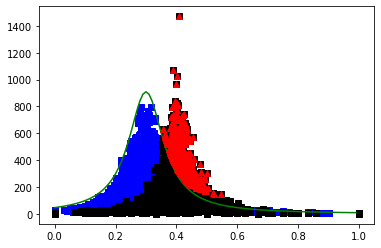

In [23]:


### final parameters for not suspicious people
pn = (gn,x0n,An)



def outlayers_D (io, trans, param, eps = 50):
### this function detect people acting suspicious comparing the following parameters:
### IO_ratio and transaction number
### not suspicious people fit perfectly inside the bell of Caushy distribution
### suspicious people lie in the distribution with different parameters
### returns True if the person doesn't fit the first bell
    
### the parameters for the Caushy distribution could be found more sophisticatly

### the parameret eps is an error margin, can be determined nices
### but even taken to be 0 gives only 6(!) not suspicious people out of the line
    F0 = Caushy(io, param[0], param[1], param[2])
    if F0 + eps < trans:
        return True
    else:
        return False




### that gonna be the list of rised flags
FLAG_D = []

### to be shown on a plot
flag_x = []
flag_y = []


with open('downloads/large.csv', 'r') as data:
    
    reader = csv.DictReader(data, delimiter = ",")     
    for line in reader:
        if int(line['category']) == 0 and int(line['age']) > 0:
            if outlayers_D(float(line['io_ratio']), float(line['transaction_count']), pn):
                flag_x.append(float(line['io_ratio']))
                flag_y.append(float(line['transaction_count']))
                FLAG_D.append(int(line[cif]))


plt.plot(a1_non_X, a1_non_Y, 'bs')
plt.plot (a1_susp_X, a1_susp_Y, 'ks')
plt.plot(x, yn, 'g-')
plt.plot(flag_x, flag_y, 'r^')
plt.show() 

In [25]:
len(FLAG_D)

478

In [28]:
matches = 0
for cif_num in FLAG_D:
    if np.isin(cif_num, df_result): matches += 1
        
print("for (df.is_pep == 1)", len(FLAG_D), matches)

for (df.is_pep == 1) 478 477


In [128]:
check_matches(FLAG_D)

Number of red flags: 478 False positives: 0.21%
